#### This is a [jupyter](https://jupyter.org/) notebook that contains text, equations, images and executable code in one document. It makes use of  [FEniCS](https://fenicsproject.org/), an open-source framework supporting Finite Element Methods.

In [1]:
%matplotlib notebook
import dolfin as df
import mshr
import matplotlib.pyplot as plt

# Finite Element Method for sound fields
## 1 Partition of the domain

The first step of the FEM is the partition of the domain into simply shaped sub-domains. These are called the **Finite Elements**. The reason for this will become evident later on, when we will learn how to perform the integration over the domain. The integral is more easy to solve if we split it into a sum of integrals over the elements.

\begin{equation}
\int_\Omega ... dV = \sum_i \int_{\Omega_i} ... dV
\end{equation}

The process of partitioning will generate a **mesh**. A mesh is a collection of nodes end elements. Each element is assigned some nodes, while each node is assigned to one or more elements.

### Elements

In acoustics, the domain may be one-, two-, or three-dimensional. Depending on the dimensionality, different element shapes may be used.

For one-dimensional domains (representing pipes and similar) the elements are lines. Here are some examples of such line elements (straight or curved) with two, three and four nodes:

<IPython.core.display.Javascript object>


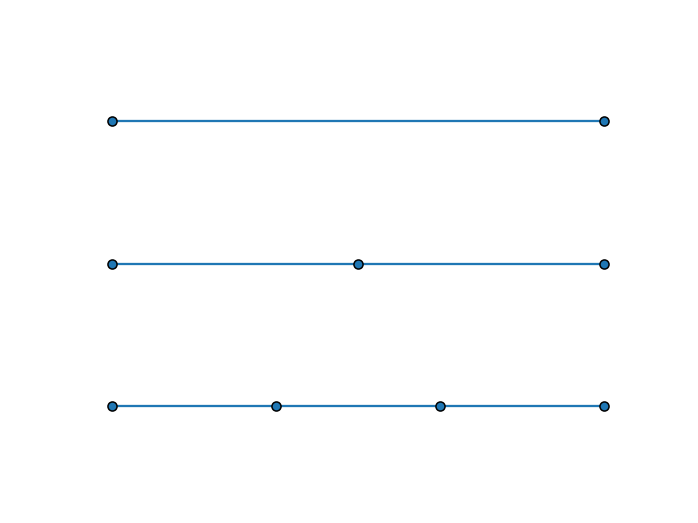

In [2]:
plt.figure()
for order in range(1,4):
    plt.subplot(3,1,order)
    df.plot(df.UnitIntervalMesh(order), marker='o', markeredgecolor='k')
    plt.gca().axis("off");

For two-dimensional domains, the elements are generally polygons. It is common to use either triangles or quadrilaterals. Here is an example with triangle elements with three and with six nodes:

<IPython.core.display.Javascript object>


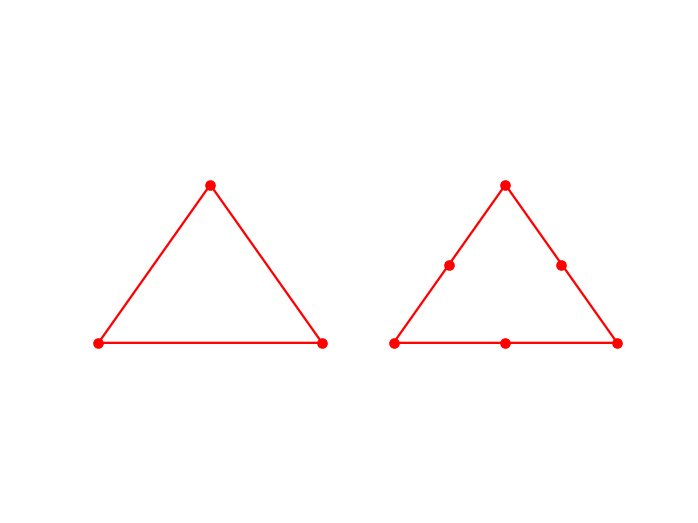

In [3]:
plt.figure()
shape = mshr.Polygon([df.Point(0.,0.),df.Point(1.,0.),df.Point(0.5,0.707)])
mesh = mshr.generate_mesh(shape,0.5)
plt.subplot(1,2,1)
df.plot(mesh,marker='o',color='r')
plt.gca().axis("off")
plt.subplot(1,2,2)
df.plot(mesh,marker='o',color='r')
plt.plot([0.5,0.25,0.75],[0,0.35,0.35],'o',color='r')
plt.gca().axis("off");


Finally, in case of three-dimensional domains, the elements are polyhedrons. Tetrahedron, hexahedron, pyramids and wedges are the most common shapes. The example shows a tretrahedron with four nodes.

<IPython.core.display.Javascript object>


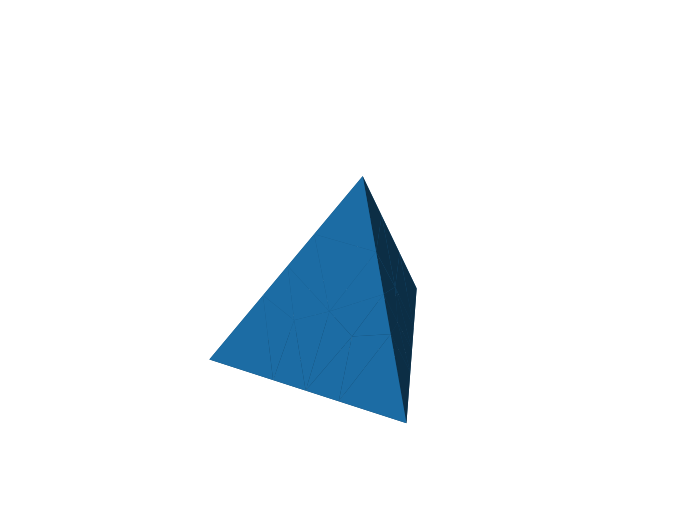

In [4]:
plt.figure()
shape = mshr.Tetrahedron(df.Point(0.,0.,0.),df.Point(1.,0.,0.),
                          df.Point(0.5,0.707,0.),df.Point(0.5,0.35,0.577))
mesh = mshr.generate_mesh(shape,1)
df.plot(mesh)
plt.gca().axis("off");
#from IPython.core.display import HTML
#xxx= df.X3DOM.html(mesh)
#xxx =df._plot_x3dom()
#dir(xxx)
#xxx.set_diffuse_color((1,0,0))
#xxx.set_menu_display(False)
#(mesh.coordinates())
#HTML(df.X3DOM.html(mesh,xxx))

### Meshes
The partition of a given domain into finite elements can be achieved in many ways. In practice we will rely on some algorithm doing the work. Depending on the kind of algorithm the outcome can be controlled using parameters, such as the minimum or maximum size of the elements or the number of elements.

The following example of a 2D domain shaped like a cross-section of a car interior will demonstrate this. It becomes also obvious that the generic triangle shape of the elements needs to get distorted in order to produce the mesh. The algorithm tries to produce a mesh where the elements are not too different in size and have edges that are not too different in length.

<IPython.core.display.Javascript object>


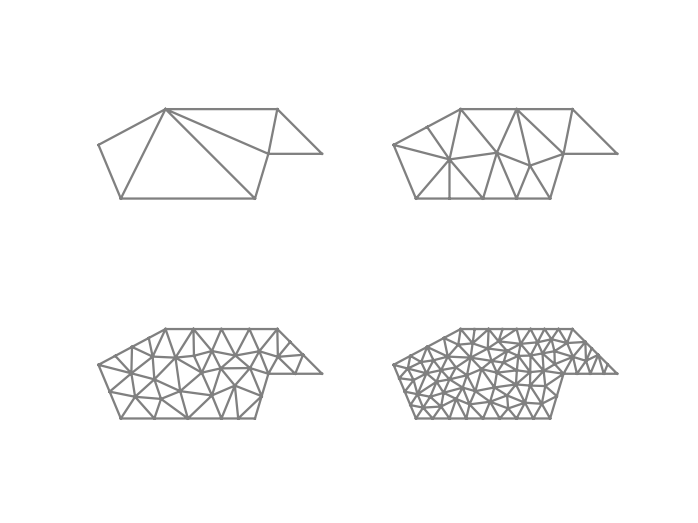

In [5]:
plt.figure()
car = mshr.Polygon([df.Point(0.,0.),df.Point(3.,0.),df.Point(3.3,1),df.Point(4.5,1),
                     df.Point(3.5,2),df.Point(1.,2),df.Point(-.5,1.2)])
for i in range(1,5):
    plt.subplot(2,2,i)
    df.plot(mshr.generate_mesh(car,i**1.5))
    plt.gca().axis("off");

Complicated three dimensional shapes are most easily meshed using tetrahedrons.

<IPython.core.display.Javascript object>


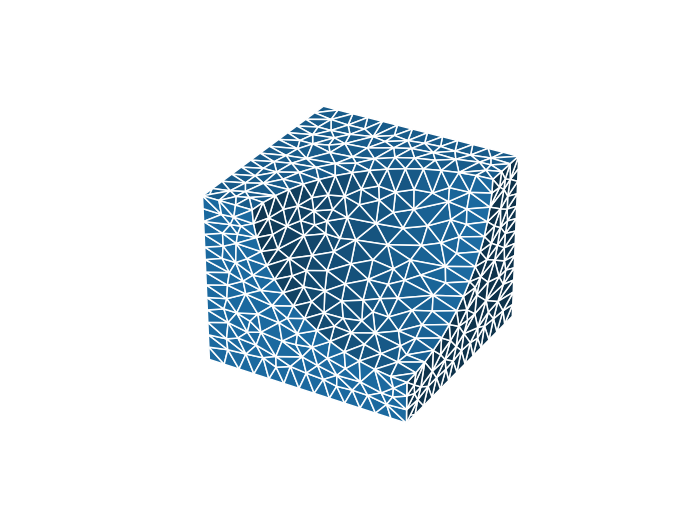

In [6]:
plt.figure()
domain = mshr.Box(df.Point(-1,-1,-1), df.Point(1,1,1)) - \
         mshr.Sphere(df.Point(1,-1,1), 1.5)
df.plot(mshr.generate_mesh(domain,20),edgecolor='w')
plt.gca().axis("off");

## 2 Interpolation of field quantities inside the finite elements

The second step in the FEM is the interpolation of the field quantity (e.g. sound pressure) inside each of the finite elements. This can be achieved using a general interpolation

\begin{equation}
p(\mathbf{x})=\sum_i N_i(\mathbf{x}) p_i=\mathbf{N}^\mathrm{T}\mathbf{p}
\end{equation}

where the supporting points $i$ are the nodes of the finite element (see examples). The interpolating functions are the **shape functions** $N_i$. The choice of these shape functions is important to provide some mathematical properties to the interpolation that are of advantage later on, when the interpolation is used as part of integrands. The values of the field quantity (or generally field quantities) $p_i$ at the nodes are the **degrees of freedom** (DOF). In acoustics it is often sufficient to have just one DOF - the sound pressure $p$.

## 3 Integral formulation
To complete the FEM, we need a formulation of the generic problem (PDE, BC) in a form with only integrals. These have then to be computed. This can be achieved by either using
- a variational approach to formulate the integrals (the PDE is needed only implicitly)
- the transformation of the PDE into definite integrals over the elements

We will have a look into the details later on. To wet you appetite, we use the car interior from above and compute the sound field produced by a source at a frequency of 200 Hz.

<IPython.core.display.Javascript object>


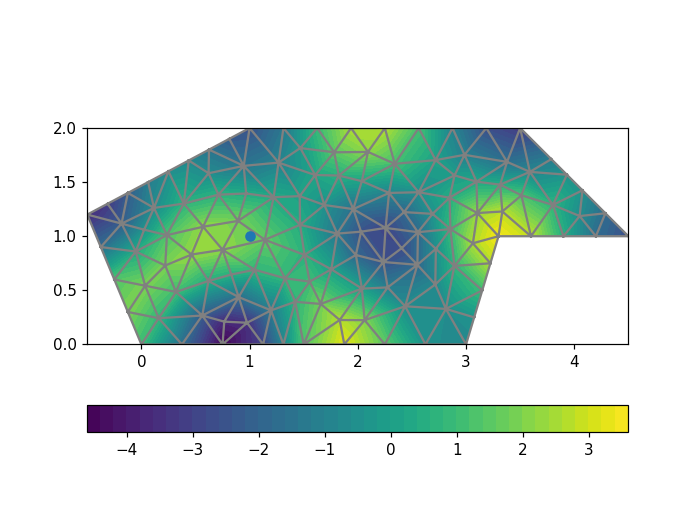

In [7]:
plt.figure()
mesh = mshr.generate_mesh(car,10)
freq = 220.
c = 343.
k2 = df.Constant(2*df.pi*freq/c)**2
V = df.FunctionSpace(mesh, "CG", 2)
u = df.TrialFunction(V)
v = df.TestFunction(V)
a = k2 * df.inner(u, v) * df.dx \
    - df.inner(df.nabla_grad(u), df.nabla_grad(v)) * df.dx
op = df.Constant(0) * v * df.dx
A, b = df.assemble_system(a, op, None)
source = df.PointSource(V, df.Point(1,1), 1)
source.apply(b)
uf = df.Function(V)
df.solve(A, uf.vector(), b)
df.plot(mesh)
mapping = df.plot(uf)
plt.plot((1,),(1,),'o')
plt.colorbar(mapping,orientation='horizontal');


#### License

This notebook is an [Open Educational Resource](https://en.wikipedia.org/wiki/Open_educational_resources). Feel free to use it for your own purposes. The text and the images are licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), and any code under the [MIT license](https://opensource.org/licenses/MIT). Please attribute the work as follows: Ennes Sarradj, Numerical Acoustics: Finite Element Method for sound fields, 2020.